## <span style="color:LightSlateGray;">Data Science Project</span>
# <span style="color:LightSlateGray;">Assessment of Database Performance Degradation</span>
# <span style="color:LightSlateGray;">Part 3 &ndash; Global Cache Load</span>
_CAS ADS 2019/2020 University of Berne_<br/>
_Author: Marco Bassi_, September 20, 2019

## Introduction

In Part 1 of the project the data taken from the databases DBA_HIST_SYSSTAT performance view have been cleansed. The 2nd part was about assessing the database load, by comparing load statistics of the integration database to the production database. This 3rd part is about global cache activity.

The integration database consists of two database instances that are operated in cluster mode for load balancing. The instances share the same data blocks, i.e. the data is not partitioned between the instances. The production database has the same setup.

If one instance of a database starts a request for a data block, which is currently held in the local cache of the other instance, the processing of the request follows a complex protocol involving the global cache. For this protocol a few tens of statistics exist to measure the global cache activity (_the load_) and waiting times. The goal of this 3rd part is to compare a selection of statistics covering both categories, of the integration to the production database. As in
the 2nd part we will use boxplots and apply one-tailed and two-sided Wilcoxon Rank Sum Test.

### Selection of Global Cache Load Statistics
* gc cr blocks received,
* gc current blocks received,
* gc local grants,
* gc read waits,
* gc remote grants,
* gcs messages sent,

### Selection of Global Cache Waiting Time Statistics
* gc cr block flush time,
* gc cr block receive time,
* gc current block flush time,
* gc current block receive time,
* gc current block send time,
* gc read wait time,
* global enqueue get time

### Set the environment

In [ ]:
library(data.table)
library(ggplot2)
library(reshape2)
library(broom)
library(stats)
setwd('../../data')

### Load the workspace image from Part 1 with the cleansed data

In [2]:
load(file="../analysis/R.workspaces/cleansed-data.RData")
ls()

[1] "dtNulled"

In [3]:
setkeyv(dtNulled, c("snapHour", "STAT_NAME"))
str(dtNulled)

Classes 'data.table' and 'data.frame':	114751 obs. of  4 variables:
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME : chr  "ADG parselock X get attempts" "ADG parselock X get successes" "Batched IO (bound) vector count" "Batched IO (full) vector count" ...
 $ sumValue_I: num  0 0 0 0 0 0 0 0 0 0 ...
 $ sumValue_P: num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME"


### Choose the statistics to compaire the two databases loads:
* application wait time (in centiseconds)
* cluster wait time (in centiseconds)
* concurrency wait time (in centiseconds)
* user I/O wait time (in centiseconds)
* db block changes (number)
* enqueue requests (number)
* execute count (number)
* global enqueue gets async (number)
* global enqueue gets sync (number)
* parse count (total, number)
* user calls (number)

In [4]:
dtNulled.selectCluster <- dtNulled[ STAT_NAME %in% list(
  "gc cr block flush time",
  "gc cr block receive time",
  "gc cr blocks received",
  "gc current block flush time",
  "gc current block receive time",
  "gc current block send time",
  "gc current blocks received",
  "gc local grants",
  "gc read wait time",
  "gc read waits",
  "gc remote grants",
  "gcs messages sent",
  "global enqueue get time"), ]

In [5]:
# Transform the data.table into long format for further analysis
dtNulled.selectCluster.melt <- melt(dtNulled.selectCluster, id=c("snapHour", "STAT_NAME"), measured=c("sumValue_I","sumValue_P"))
setkeyv(dtNulled.selectCluster.melt, c("snapHour", "STAT_NAME", "variable")) 
str(dtNulled.selectCluster.melt)

Classes 'data.table' and 'data.frame':	4394 obs. of  4 variables:
 $ snapHour : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ STAT_NAME: chr  "gc cr block flush time" "gc cr block flush time" "gc cr block receive time" "gc cr block receive time" ...
 $ variable : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 2 1 2 1 2 1 2 1 2 ...
 $ value    : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME" "variable"


### Compute the statistic deltas between the subsequent snapshots
As the statistics are running sums, we will have to compute the deltas between subsequent snapshots, grouped by statistic name (_STAT_NAME_) and database (_variable_).

In [6]:
dtNulled.selectCluster.melt.diff <- dtNulled.selectCluster.melt[, 
list(snapHour, "deltaValue" = rep(diff(value), length.out = length(snapHour))), by=list(STAT_NAME, variable)]
setkeyv(dtNulled.selectCluster.melt.diff, c("snapHour", "STAT_NAME", "variable"))
str(dtNulled.selectCluster.melt.diff)

Classes 'data.table' and 'data.frame':	4394 obs. of  4 variables:
 $ STAT_NAME : chr  "gc cr block flush time" "gc cr block flush time" "gc cr block receive time" "gc cr block receive time" ...
 $ variable  : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 2 1 2 1 2 1 2 1 2 ...
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 00:00:00" ...
 $ deltaValue: num  219 208 36552 25984 678134 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "snapHour" "STAT_NAME" "variable"


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">Same issue with recycling upon computation of deltas as in part 2. Thus, as a consequence, the duplicates are set to NA.</span>

In [7]:
dtNulled.selectCluster.melt.diff[snapHour == as.POSIXct("2019-08-29 00:00:00", format="%Y-%m-%d %H:%M:%S"), deltaValue := NA]

#### Summary of the data

In [8]:
summarySystatByPlatform.cluster.diff <- dtNulled.selectCluster.melt.diff[, glance(summary(deltaValue)), by=list(STAT_NAME, variable)]
setkeyv(summarySystatByPlatform.cluster.diff, c("STAT_NAME", "variable"))

# Compute the interquartile ranges; they will be needed later to exclude outliers
summarySystatByPlatform.cluster.diff[, IQR := q3 - q1]
summarySystatByPlatform.cluster.diff[]

STAT_NAME,variable,minimum,q1,median,mean,q3,maximum,na,IQR
gc cr block flush time,sumValue_I,219,2991.50,4318.5,5.695206e+03,6302.25,132897,9,3310.75
gc cr block flush time,sumValue_P,208,1901.25,2913.0,2.985548e+03,3606.25,10632,1,1705.00
gc cr block receive time,sumValue_I,23933,209352.75,329966.0,3.861591e+05,496389.50,6560186,9,287036.75
gc cr block receive time,sumValue_P,11207,58161.25,98338.0,9.369492e+04,131489.00,186777,1,73327.75
gc cr blocks received,sumValue_I,351574,1870143.75,2863960.5,2.859450e+06,3511972.75,43739457,9,1641829.00
gc cr blocks received,sumValue_P,393816,1818985.00,2824363.5,2.716082e+06,3730623.25,5026411,1,1911638.25
gc current block flush time,sumValue_I,241,1624.00,2180.5,3.372875e+03,2577.00,66663,9,953.00
gc current block flush time,sumValue_P,165,1244.50,1737.0,2.225857e+03,2091.00,18209,1,846.50
gc current block receive time,sumValue_I,46888,264485.50,407135.0,4.862190e+05,604765.25,9792169,9,340279.75
gc current block receive time,sumValue_P,8556,68368.75,121932.5,1.150149e+05,157077.00,242672,1,88708.25


In [9]:
# Extract statistic names into a vector
statNames <- unique(dtNulled.selectCluster.melt.diff[, STAT_NAME])

### Test the global cache load statistics, using the Wilcoxon Rank Sum Test

In [10]:
## Cluster statistics not measuring time, but quantities related to global cache load
statNames.gcload <- grep(".+time$", statNames, value=TRUE, invert=TRUE)
statNames.gcload

[1] "gc cr blocks received"      "gc current blocks received"
[3] "gc local grants"            "gc read waits"             
[5] "gc remote grants"           "gcs messages sent"

#### <span style="font-style: italic;  font-weight:600;color: DarkGreen; font-size:1em;">Null Hypothesis: The median of the global cache load statistic on the integration and production databases is equal.</span>
#### <span style="font-style: italic; font-weight: 600; color: DarkGreen; font-size:1em;">Alternative Hypothesis: The median is not equal.</span>
For this test we compute a two-sided Wilcoxon Rank Sum Test.

In [11]:
## Wilcox rank sum test for global cache load statistics, with outliers included
## H0: Q50(Inte) = Q50(Prod), i.e. equal median of global cache load on both databases
i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe.forGCLoad = list()
for (sName in statNames.gcload) {
    w <- wilcox.test(deltaValue ~ variable, data=dtNulled.selectCluster.melt.diff, paired=F, 
      alternative = "two.sided", na.action = na.omit, subset = dtNulled.selectCluster.melt.diff[, STAT_NAME == sName])
    wtListe.forGCLoad[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest.forGCLoad <- data.frame(statNames.gcload, pval, h1, method)
colnames(wilcoxTest.forGCLoad) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest.forGCLoad

statistik,p.value,alternative,method
gc cr blocks received,2.799559e-01,two.sided,Wilcoxon rank sum test with continuity correction
gc current blocks received,1.612864e-01,two.sided,Wilcoxon rank sum test with continuity correction
gc local grants,8.081017e-01,two.sided,Wilcoxon rank sum test with continuity correction
gc read waits,2.593493e-14,two.sided,Wilcoxon rank sum test with continuity correction
gc remote grants,1.310366e-05,two.sided,Wilcoxon rank sum test with continuity correction
gcs messages sent,7.857521e-06,two.sided,Wilcoxon rank sum test with continuity correction


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">For half of the  statistics the null hypothesis must be discarded in favour of the alternative hypothesis. We repeat the test, but this time we will exclude outliers.</span>

In [12]:
summarySystatByPlatform.cluster.diff[, IQR := q3 - q1]

dtNulled.selectCluster.melt.diff.ext <- merge(
   dtNulled.selectCluster.melt.diff,
   summarySystatByPlatform.cluster.diff,
   by = c("STAT_NAME", "variable"), all=T, incomparables=NA)

dtNulled.selectCluster.melt.diff.nooutlier <- dtNulled.selectCluster.melt.diff.ext[ deltaValue <= q3 + 1.5 * IQR & deltaValue >= q1 - 1.5 * IQR, ]
str(dtNulled.selectCluster.melt.diff.nooutlier)

Classes 'data.table' and 'data.frame':	4058 obs. of  12 variables:
 $ STAT_NAME : chr  "gc cr block flush time" "gc cr block flush time" "gc cr block flush time" "gc cr block flush time" ...
 $ variable  : Factor w/ 2 levels "sumValue_I","sumValue_P": 1 1 1 1 1 1 1 1 1 1 ...
 $ snapHour  : POSIXct, format: "2019-08-22 00:00:00" "2019-08-22 01:00:00" ...
 $ deltaValue: num  219 792 3247 5937 3553 ...
 $ minimum   : num  219 219 219 219 219 219 219 219 219 219 ...
 $ q1        : num  2992 2992 2992 2992 2992 ...
 $ median    : num  4318 4318 4318 4318 4318 ...
 $ mean      : num  5695 5695 5695 5695 5695 ...
 $ q3        : num  6302 6302 6302 6302 6302 ...
 $ maximum   : num  132897 132897 132897 132897 132897 ...
 $ na        : num  9 9 9 9 9 9 9 9 9 9 ...
 $ IQR       : num  3311 3311 3311 3311 3311 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr  "STAT_NAME" "variable"


In [13]:
## Wilcox rank sum test for global cache load statistics, with outliers excluded
## H0: Q50(Inte) = Q50(Prod), i.e. equal medians of global cache load statistics on both databases
i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe.forGCLoad.no = list()
for (sName in statNames.gcload) {
    w <- wilcox.test(deltaValue ~ variable, data=dtNulled.selectCluster.melt.diff.nooutlier, paired=F, 
      alternative = "two.sided", na.action = na.omit, subset = dtNulled.selectCluster.melt.diff.nooutlier[, STAT_NAME == sName])
    wtListe.forGCLoad.no[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest.forGCLoad.no <- data.frame(statNames.gcload, pval, h1, method)
colnames(wilcoxTest.forGCLoad.no) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest.forGCLoad.no

statistik,p.value,alternative,method
gc cr blocks received,2.365051e-01,two.sided,Wilcoxon rank sum test with continuity correction
gc current blocks received,1.905376e-01,two.sided,Wilcoxon rank sum test with continuity correction
gc local grants,1.314901e-03,two.sided,Wilcoxon rank sum test with continuity correction
gc read waits,1.020914e-17,two.sided,Wilcoxon rank sum test with continuity correction
gc remote grants,4.021448e-03,two.sided,Wilcoxon rank sum test with continuity correction
gcs messages sent,4.470929e-06,two.sided,Wilcoxon rank sum test with continuity correction


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">Now we have to reject the null hypothesis for 4 statistics (was 3 with outliers included). In the case of gc remote grants, the decision in favour of H1 is quite narrow. For the 4 statistics where we discard H0, we go for a one-tailed test.</span>

#### <span style="font-style: italic;  font-weight:600;color: DarkGreen; font-size:1em;">Null Hypothesis: The median of the global cache load statistic on the integration database is greater than or equal to the median on the production database.</span>
#### <span style="font-style: italic; font-weight: 600; color: DarkGreen; font-size:1em;">The median of the global cache load statistic on the integration database is smaller than the median on the production databases.

In [14]:
## Wilcox rank sum test for global cache load statistics, with outliers excluded
## H0: Q50(Inte) >= Q50(Prod), i.e. equal medians of global cache load statistics on both databases
statNames.gcload.subset <- c("gc local grants", "gc read waits", "gc remote grants", "gcs messages sent")
i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe.forGCLoad.no.subset = list()
for (sName in statNames.gcload.subset) {
    w <- wilcox.test(deltaValue ~ variable, data=dtNulled.selectCluster.melt.diff.nooutlier, paired=F, 
      alternative = "less", na.action = na.omit, subset = dtNulled.selectCluster.melt.diff.nooutlier[, STAT_NAME == sName])
    wtListe.forGCLoad.no.subset[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest.forGCLoad.no.subset <- data.frame(statNames.gcload.subset, pval, h1, method)
colnames(wilcoxTest.forGCLoad.no.subset) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest.forGCLoad.no.subset

statistik,p.value,alternative,method
gc local grants,6.574507e-04,less,Wilcoxon rank sum test with continuity correction
gc read waits,1.000000e+00,less,Wilcoxon rank sum test with continuity correction
gc remote grants,2.010724e-03,less,Wilcoxon rank sum test with continuity correction
gcs messages sent,2.235465e-06,less,Wilcoxon rank sum test with continuity correction


<span style="font-style: italic; color: LightSlateGray; font-size:1.1em;">For all but _gc read waits_ we reject the null hypothesis in favour of the alternative, i.e. the medians for those statistics are greater on the production database than on the integration database. The statistic _gc read waits_ however has values several order of magnitudes smaller than the other global cache load statistics; see the data summary above. Thus it will not be taken into account for the conclusions.

### Test the global cache waiting time statistics, using the Wilcoxon Rank Sum Test

In [15]:
## Cluster statistics measuring global cache waiting times
statNames.time <- grep(".+time$", statNames, value=TRUE, invert=FALSE)
statNames.time

[1] "gc cr block flush time"        "gc cr block receive time"     
[3] "gc current block flush time"   "gc current block receive time"
[5] "gc current block send time"    "gc read wait time"            
[7] "global enqueue get time"

#### <span style="font-style: italic;  font-weight:600;color: DarkGreen; font-size:1em;">Null Hypothesis: The median of the global cache waiting time statistic on the integration database is greater than or equal to the median on the production database.</span>
#### <span style="font-style: italic; font-weight: 600; color: DarkGreen; font-size:1em;">Alternative Hypothesis: The median on the integration database is smaller than the median on the production database.</span>
For this test we compute a one-tailed Wilcoxon Rank Sum Test.

In [16]:
## Wilcox rank sum test global cache waiting time statistics, with outliers included
## H0: Q50(Inte) <= Q50(Prod), i.e. median of global cache waiting times is higher on Prod than on Inte
## H1: Q50(Inte) > Q50(Prod), i.e. median is higher on Inte
i = 1
pval = c()
h1 = c()       # Alternative Hypothese
method = c()   # Methode
wtListe.forGCWaitingTime = list()
for (sName in statNames.time) {
    w <- wilcox.test(deltaValue ~ variable, data=dtNulled.selectCluster.melt.diff, paired=F, alternative = "greater", 
      na.action = na.omit, subset = dtNulled.selectCluster.melt.diff[, STAT_NAME == sName])
    wtListe.forGCWaitingTime[[sName]] = w
    pval[i] <- w[["p.value"]]
    h1[i] <- w[["alternative"]]
    method[i] = w[["method"]]
    i = i + 1
}

wilcoxTest.forGCWaitingTime <- data.frame(statNames.time, pval, h1, method)
colnames(wilcoxTest.forGCWaitingTime) <- c("statistik", "p.value", "alternative", "method")

wilcoxTest.forGCWaitingTime

statistik,p.value,alternative,method
gc cr block flush time,1.744369e-13,greater,Wilcoxon rank sum test with continuity correction
gc cr block receive time,3.230590e-35,greater,Wilcoxon rank sum test with continuity correction
gc current block flush time,1.295017e-07,greater,Wilcoxon rank sum test with continuity correction
gc current block receive time,5.143932e-41,greater,Wilcoxon rank sum test with continuity correction
gc current block send time,1.000000e+00,greater,Wilcoxon rank sum test with continuity correction
gc read wait time,2.003196e-02,greater,Wilcoxon rank sum test with continuity correction
global enqueue get time,1.965542e-03,greater,Wilcoxon rank sum test with continuity correction


<p style="font-style: italic; color: LightSlateGray; font-size:1.1em;">The null hypothesis is discarded in favour of the alternative hypothesis for six out of seven Global Cache waiting time statistics; i.e. we have higher cluster waiting times on the integration database than on the production database. The result for _gc current block send time_ can be discarded, as the value is 0 for all snapshots. Obviously this statistic is not captured.</p>
<p style="font-style: italic; color: LightSlateGray; font-size:1.1em; margin-top:1em;">Doing the same test with outliers excluded confirms these results. The test is skipped here</p>

## Conclusions
* The global cache load of the integration database is equal to or smaller than the load of the production database.
* The global cache waiting times are higher on the integration database than on the production database.
* Thus, there is not a higher global cache activity on the integration database (when compared to the production database), that can be held responsible for the very high cluster waiting times, when compared to the production database.

## Plotting the data

### gc cr block receive time

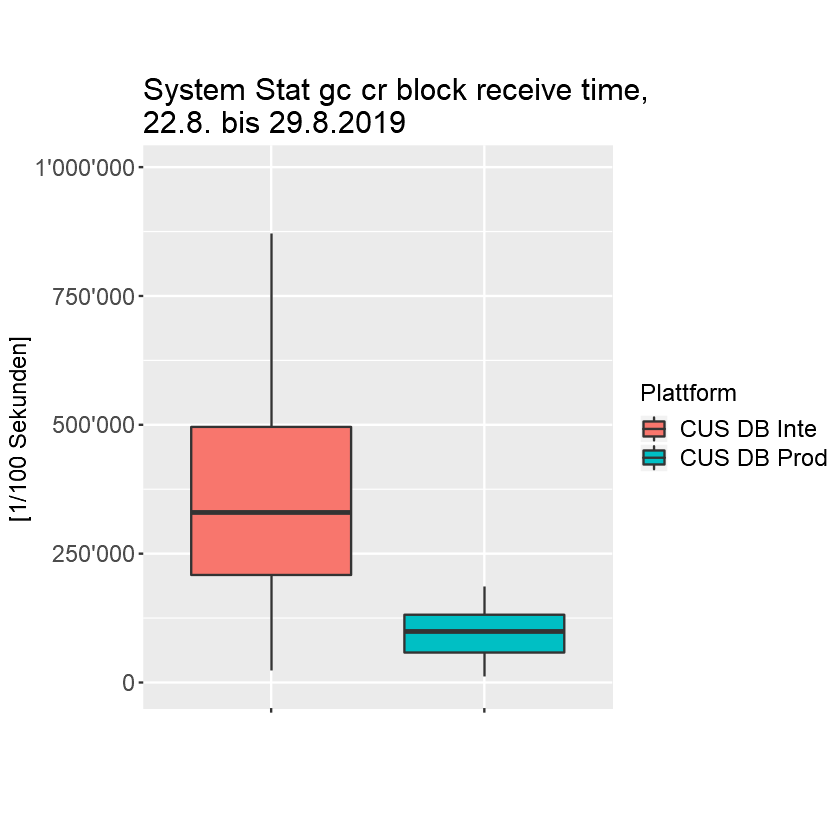

In [17]:
myTheme.screen = theme(
  aspect.ratio = 1.2,
  plot.title=element_text(size = 18),
  title = element_text(size = 14),
  axis.title.x = element_text(size = 14),
  axis.text.x = element_text(size = 14),
  axis.title.y = element_text(size = 14),
  axis.text.y = element_text(size = 14),
  legend.title = element_text(size = 14),
  legend.text = element_text(size = 14)  
)

myTheme.plot = theme(
  plot.title=element_text(size = 28, face="bold"),
  title = element_text(size = 24),
  axis.title.x = element_text(size = 24),
  axis.text.x = element_text(size = 24),
  axis.title.y = element_text(size = 24),
  axis.text.y = element_text(size = 24),
  legend.title = element_text(size = 24, face="bold"),
  legend.text = element_text(size = 24)
)

statName <- "gc cr block receive time"
y_max =  2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[1/100 Sekunden]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
  scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_cr_block_receive_time.png")

### gc cr block flush time

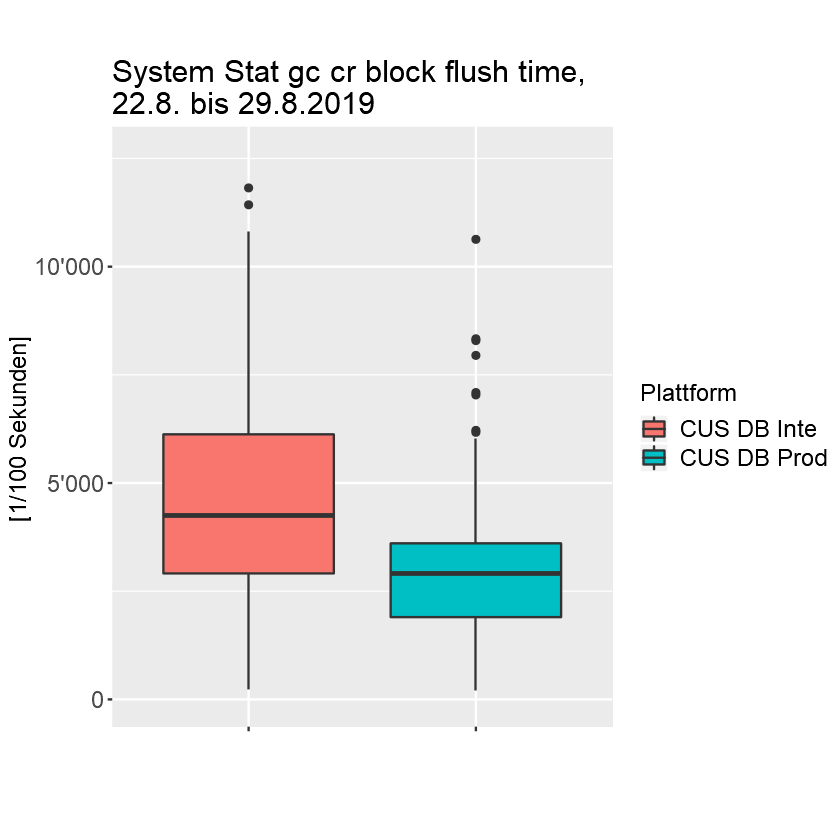

In [18]:
statName <- "gc cr block flush time"
y_max =  2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[1/100 Sekunden]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
  scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_cr_block_flush_time.png")

### gc current block receive time

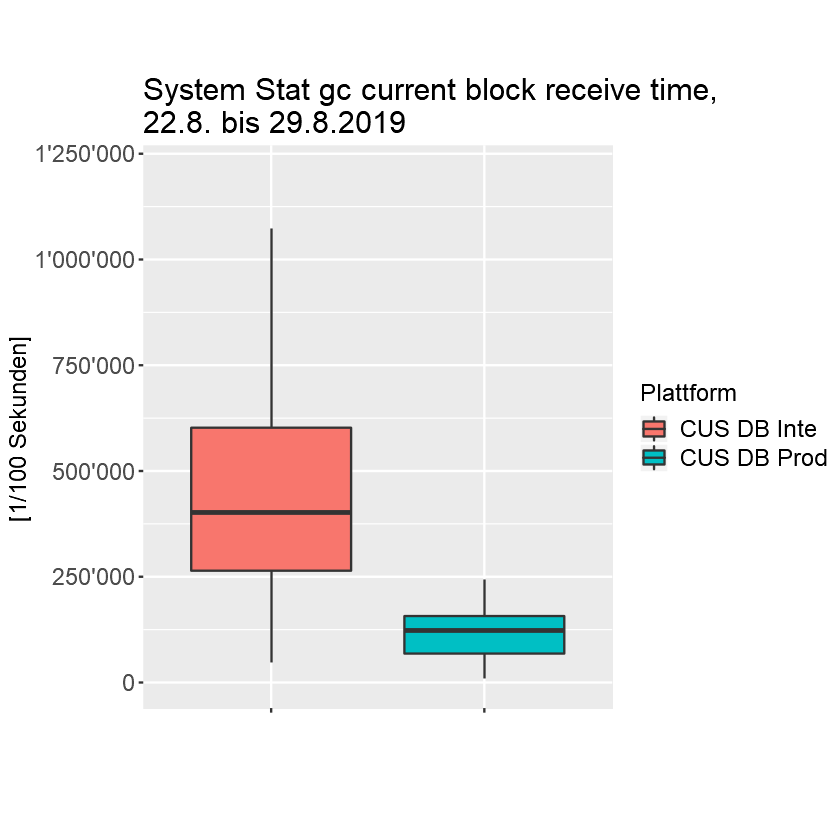

In [19]:
statName <- "gc current block receive time"
y_max =  2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[1/100 Sekunden]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
  scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen
## plot(p_5)

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_current_block_receive_time.png")

### gc read wait time

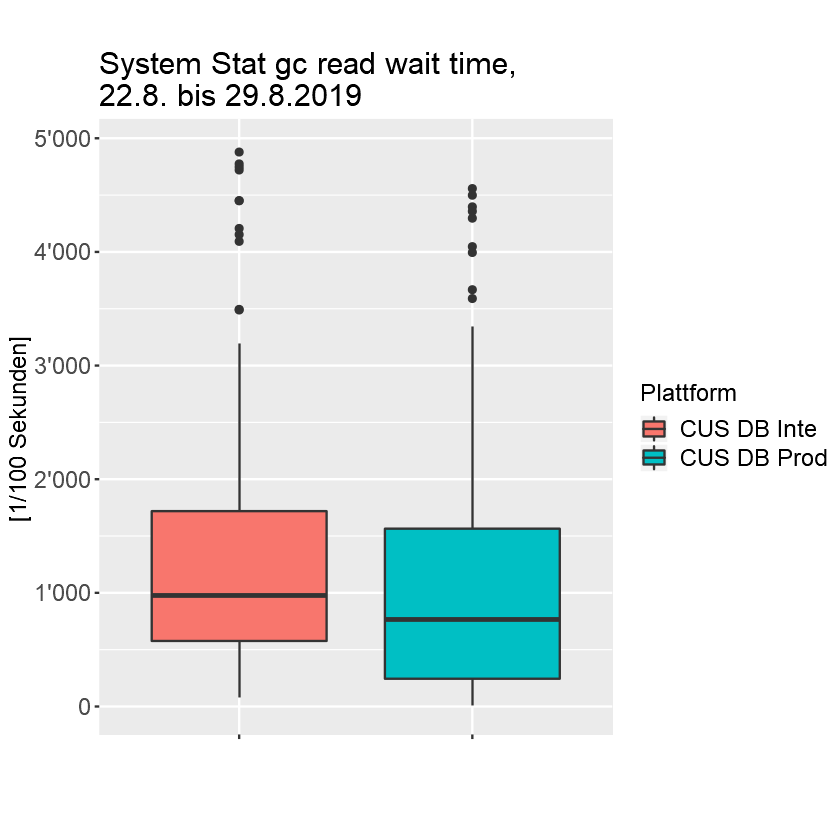

In [20]:
statName <- "gc read wait time"
y_max =  2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[1/100 Sekunden]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
  scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path='../analysis/plots', filename="sysstat.gc_read_wait_time.png")

### gc current block flush time

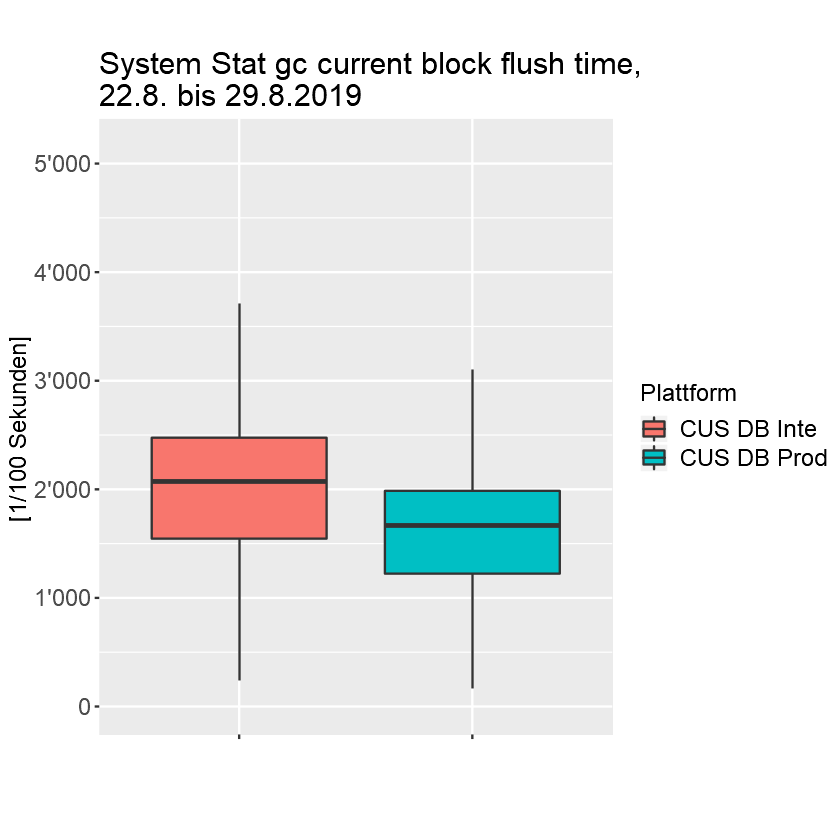

In [31]:
statName <- "gc current block flush time"
y_max =  2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[1/100 Sekunden]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
  scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_current_block_flush_time.png")

### global enqueue get time

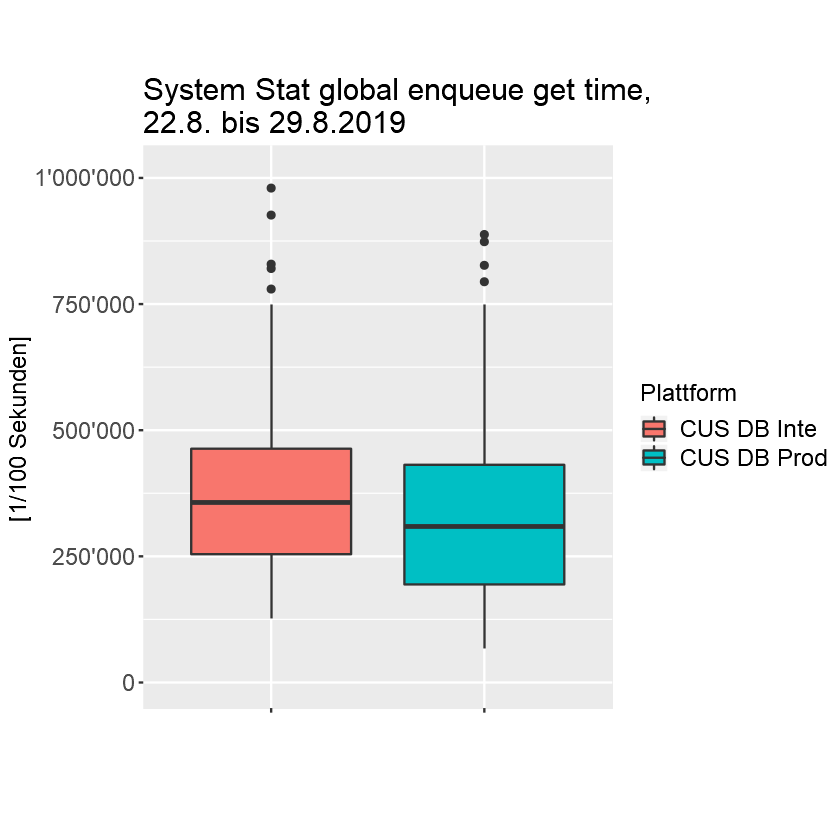

In [21]:
statName <- "global enqueue get time"
y_max =  2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[1/100 Sekunden]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
  scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path='../analysis/plots', filename="sysstat.global_enqueue_get_time.png")

### gc cr blocks received

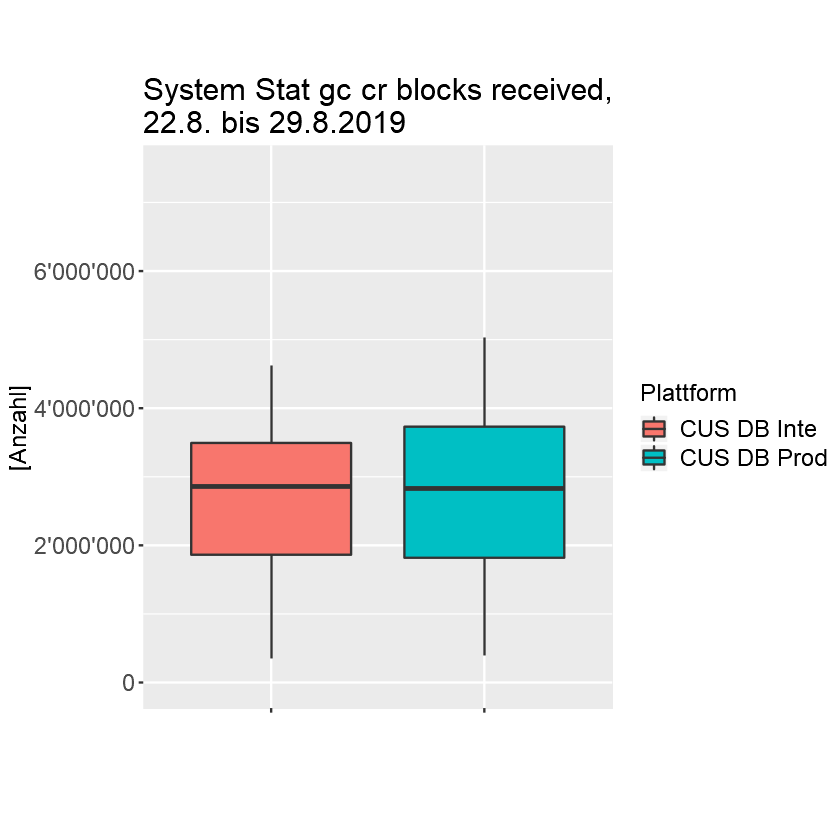

In [22]:
statName <- "gc cr blocks received"
y_max <- 2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[Anzahl]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_cr_blocks_received.png")


### gc current blocks received

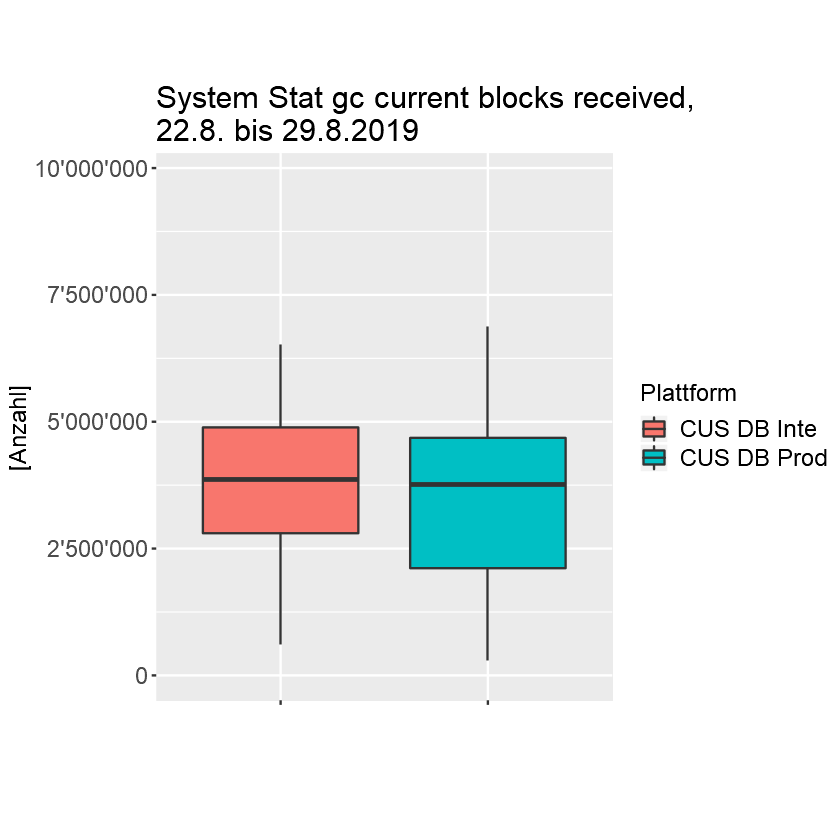

In [32]:
statName <- "gc current blocks received"
y_max <- 2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[Anzahl]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_current_blocks_received.png")

### gc local grants

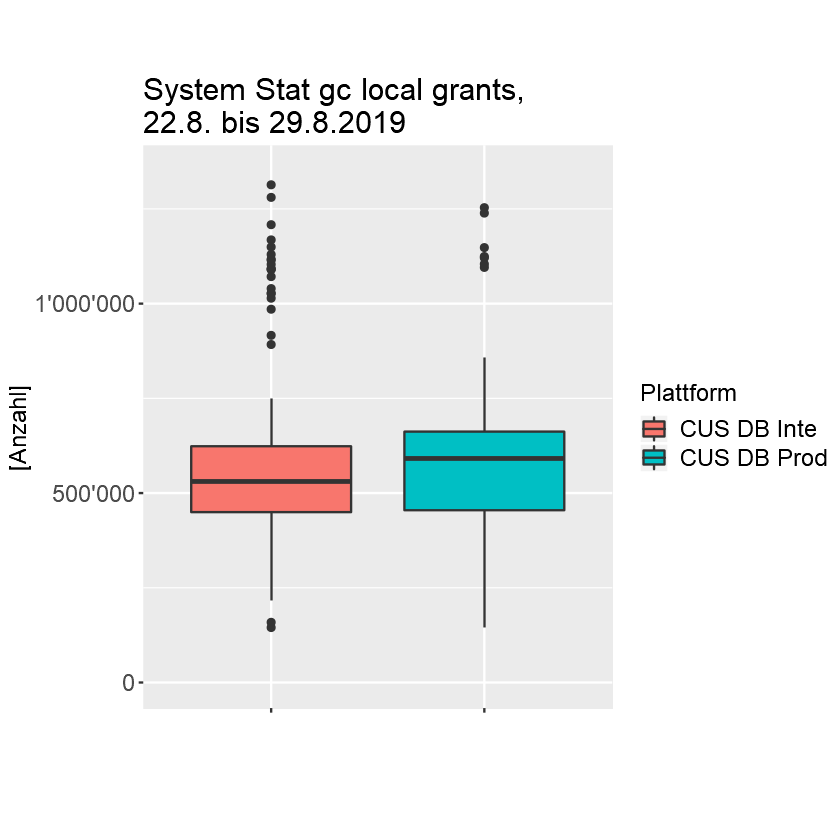

In [24]:
statName <- "gc local grants"
y_max <- 2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[Anzahl]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_local_grants.png")

### gc read waits

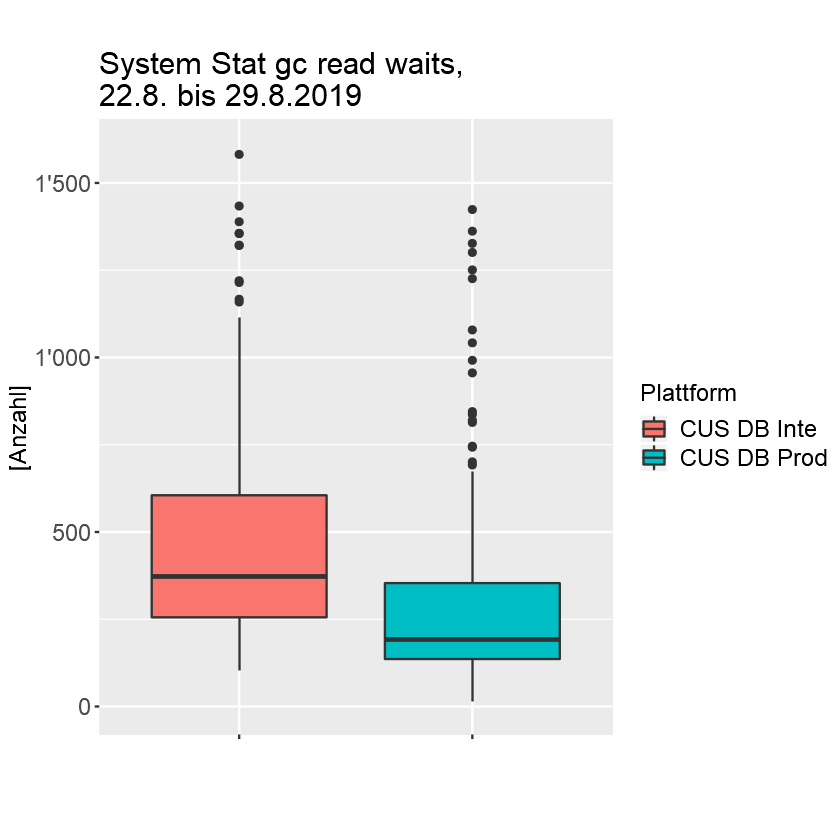

In [25]:
statName <- "gc read waits"
y_max <- 2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[Anzahl]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_read_waits.png")

### gc remote grants

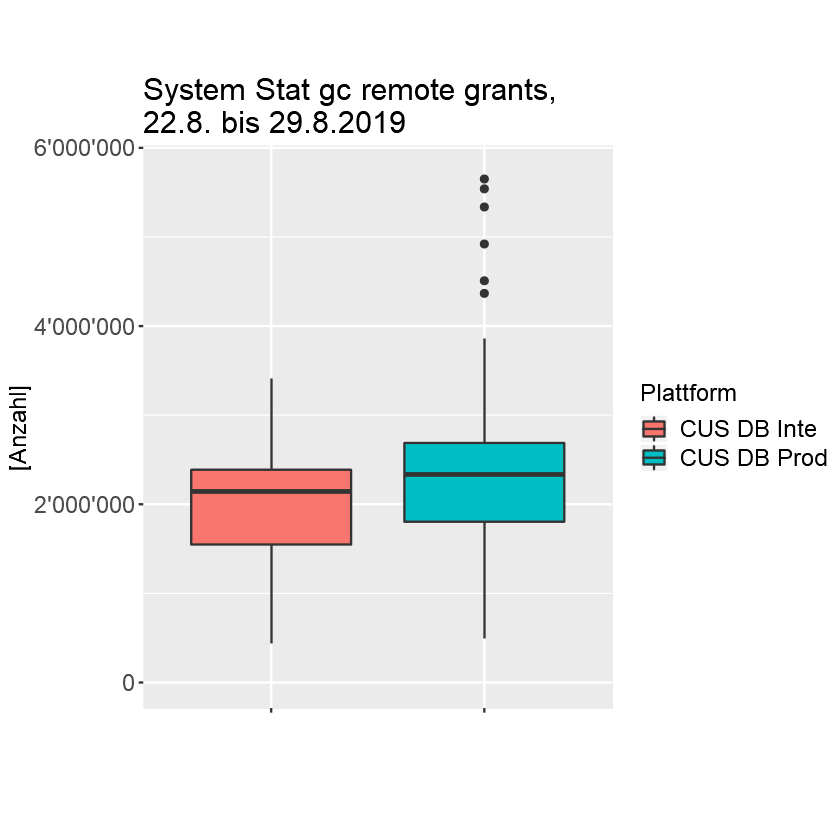

In [26]:
statName <- "gc remote grants"
y_max <- 2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[Anzahl]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gc_remote_grants.png")

### gcs messages sent

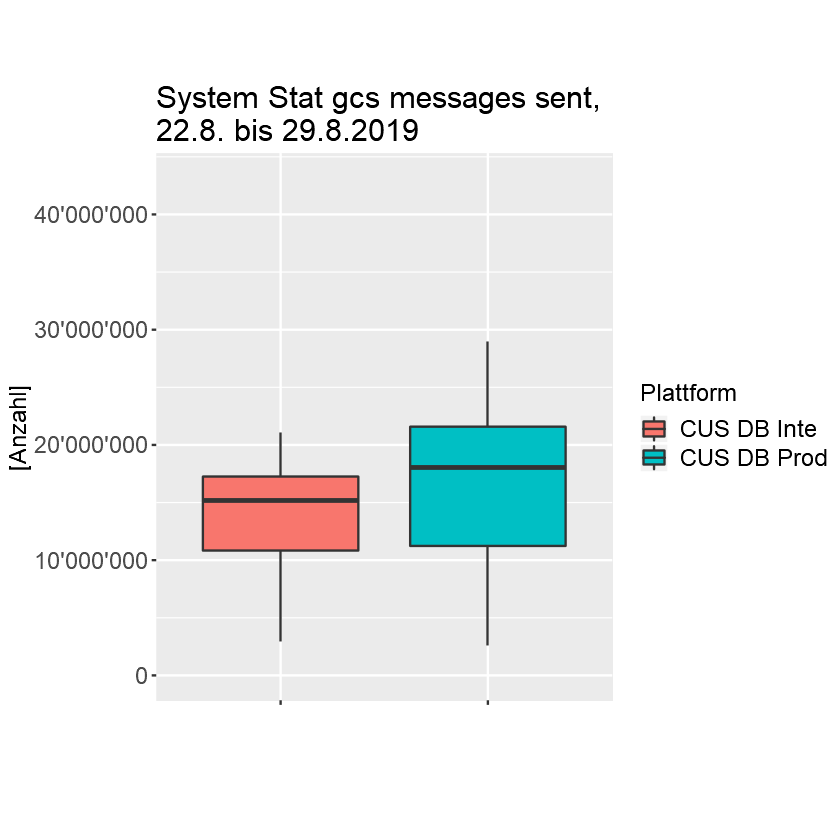

In [29]:
statName <- "gcs messages sent"
y_max <- 2 * summarySystatByPlatform.cluster.diff[ STAT_NAME == statName, max(q3)]
p <- ggplot(data=dtNulled.selectCluster.melt.diff[ STAT_NAME == statName, ])
p_1 <- p + geom_boxplot(aes(x=variable, y=deltaValue, fill=variable), stat="boxplot", na.rm=TRUE, notch=FALSE)
p_2 <- p_1 +
  scale_y_continuous(limits = c(0,y_max), labels = scales::comma_format(big.mark="'"))
p_3 <- p_2 +
  labs(title=paste("System Stat ", statName, ", \n22.8. bis 29.8.2019", sep="")) +
  ylab("[Anzahl]")
p_4 <- p_3 +
  scale_fill_discrete(name="Plattform", breaks=c("sumValue_I", "sumValue_P"), labels=c("CUS DB Inte", "CUS DB Prod")) +
    scale_x_discrete(name="", breaks=c("sumValue_I", "sumValue_P"), labels=c("",""))
p_4 + myTheme.screen

ggsave(plot=p_4 + myTheme.plot, height=15, width=25, units="cm", path="../analysis/plots", filename="sysstat.gcs_messages_sent.png")